In [149]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.integrate import quad



We consider the evaluation of the following integral
$$
\bar{f_p} = \int f(x)p(x)dx 
$$
where $p(x)$ is a probability (density), and $f(x)$ is the function we wish to integrate


- The Classical Monte Carlo Method make the approximation:

$$
\bar{f_p}=\frac{1}{T}\sum_{t=1}^{T} f(x_t)
$$

where $x_t$ are random (not necessarily independent) draws from $p(x)$.

It is also possible to draw samples from some importance sampling distribution
$q(x)$ to obtain the estimate:

$$ \bar{f_p}=\frac{1}{T}\sum_{t=1}^{T} f(x_t)\frac{p(x_t)}{q(x_t)} $$


- In the  Bayesian Monte Carlo, we proceed by putting a prior on $f$ through Gaussian Processes (GP) in this case.
Under a GP prior the joint distribution of any (finite) number of function values (indexed
by the inputs, $x$ is Gaussian: 

$$ \mathbf{f}= {(f(x_1),f(x_2), \cdot \cdot \cdot ,f(x_n) )}^T =  \mathcal{N}(0,\,K)\ $$

where the mean is taken as zero and the covariance matrix is given by the covariance
function (.....1). 
$$ K_{pq}= \mathcal{Cov}( f(x_p), f(x_q))= w_0 \exp{(-\frac{1}{2} \sum_{d=1}^{D}\frac{(x_p^{(d)}-x_q^{(d)})^2}{w_d^2})}$$

 where $w$ parameters are hyperparameters to optimize.


 Concretely, the Bayesian Monte Carlo method starts with a prior over the function, $p(f)$ and makes
inferences about $f$ from a set of samples $ \mathcal{D} = \{(x_i, f(x_i)) |i = 1 . . . n\} $ 


 (1)- The standard approximation results for a GP process is:
$f_D(x) = k(x, \mathbf{x})K^{-1}\mathbf{f}$ and $ CovD(f(x), f(x^{\prime}) = k(x, x^{\prime})−k(x, \mathbf{x})K^{-1}k(\mathbf{x}, x^{\prime}) $

where  $\mathbf{x}$ and  $\mathbf{f}$ are the observed inputs and function values respectively. General case is lead to expressions difficult to evaluate.

(2)- [Special case] If the density $p(x)$ and the covariance function are both Gaussian, i.e : $p(x)=\mathcal{N}(b,\,B)$ and the Gaussian kernel on the data point is $\mathcal{N}(a_i=x_i,\, A=diag(w_1^2, w_2^2, \cdot, \cdot, \cdot, w_D^2))$ , we obtain: 


$$\mathrm{E}_{f|\mathcal{D}}[\bar{f_p}] = z^TK^{-1}\mathbf{f} , \quad z=w_0|A^{-1}B + I|^{-0.5}\exp[-0.5(a-b)^T(A+B)^{-1}(a-b)]$$
$$\mathrm{V}_{f|\mathcal{D}}[\bar{f_p}] =  w_0| 2A^{-1}B + I|^{-0.5}  - z^TK^{-1}z$$















## Implement SMC

In [5]:
class SMC:
    def __init__(self,f,p,lwb, upb,T):
        self.f=f
        self.p=p
        self.T=T
        self.clear()
    def clear(self):
        self.x=np.zeros(self.T)
    
    def evaluate(self):
        pass

In [60]:
def smc(f,x,T):
    return 1/T*np.sum(f(x))

smc  0.9532927840541175 True inegrand:  0.9699531057009148


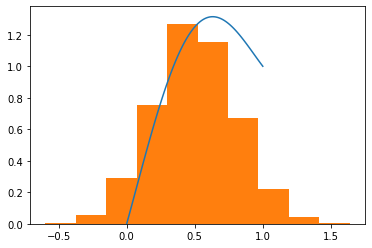

In [148]:
def f(x):
    if x>=0 and x<=1:
        return np.sin(np.pi*x)+x**2
    return 0
f=np.vectorize(f)

x=norm(loc=0.5,scale=0.3).rvs(size=10000)
print("smc ", smc(f,x,10000), "True inegrand: ", quad(f,0,1)[0])

#plot
plt.plot(np.linspace(0,1,100),f(np.linspace(0,1,100)))
plt.hist(x, density=True)
plt.show()

We can clearly notice that the choice of the gaussian distribution parameters is very important to get an aproximation close to the real integral. Indeed the sample has to be expanded on all the segment we wish to integrate and most importantly well distributed along values where the evaluation of f outputs small and big values. If we sample more  where f is  evaluated  small (resp. evaluated big), we get a lower (resp. upper opproximation). So the optimization strategie of bayesian monte carlo makes sense.